In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
# Bước 1: Đọc dữ liệu
df = pd.read_csv('data/xAPI-Edu-Data.csv')
print(df.isnull().sum())

gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64


Text(0.5, 1.0, 'Absence Days (Above/Under 7)')

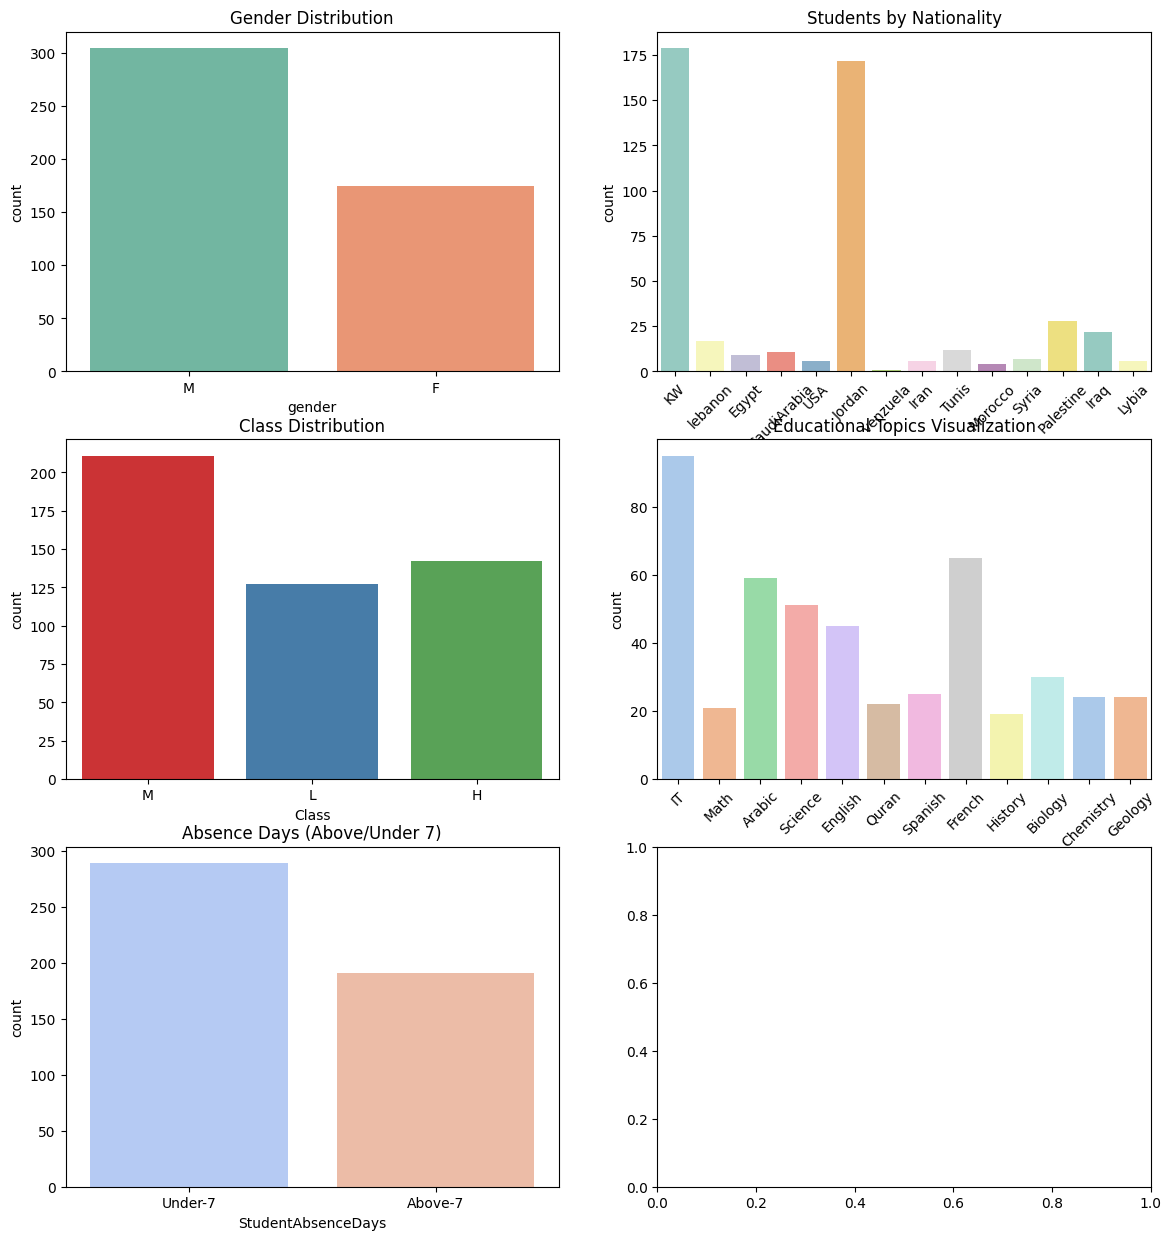

In [2]:
# Tạo Figure và Subplot
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Biểu đồ Giới tính
sns.countplot(ax=axes[0, 0], x='gender', hue='gender', data=df, palette='Set2', legend=False)
axes[0, 0].set_title('Gender Distribution')

# Biểu đồ Quốc gia
sns.countplot(ax=axes[0, 1], x='NationalITy', hue='NationalITy', data=df, palette='Set3', legend=False)
axes[0, 1].set_title('Students by Nationality')
axes[0, 1].tick_params(axis='x', rotation=45)

# Biểu đồ Class
sns.countplot(ax=axes[1, 0], x='Class', hue='Class', data=df, palette='Set1', legend=False)
axes[1, 0].set_title('Class Distribution')

# Biểu đồ Chủ đề môn học
sns.countplot(ax=axes[1, 1], x='Topic', hue='Topic', data=df, palette='pastel', legend=False)
axes[1, 1].set_title('Educational Topics Visualization')
axes[1, 1].tick_params(axis='x', rotation=45)

# Biểu đồ Số ngày nghỉ
sns.countplot(ax=axes[2, 0], x='StudentAbsenceDays', hue='StudentAbsenceDays', data=df, palette='coolwarm', legend=False)
axes[2, 0].set_title('Absence Days (Above/Under 7)')

In [3]:
le = LabelEncoder()
df['StageID'] = le.fit_transform(df['StageID'])
df['GradeID'] = le.fit_transform(df['GradeID'])
df['SectionID'] = le.fit_transform(df['SectionID'])
df['Semester'] = le.fit_transform(df['Semester'])
df['gender'] = le.fit_transform(df['gender'])
df['NationalITy'] = le.fit_transform(df['NationalITy'])
df['PlaceofBirth'] = le.fit_transform(df['PlaceofBirth'])
df['Topic'] = le.fit_transform(df['Topic'])
df['Relation'] = le.fit_transform(df['Relation'])
df['ParentAnsweringSurvey'] = le.fit_transform(df['ParentAnsweringSurvey'])
df['ParentschoolSatisfaction'] = le.fit_transform(df['ParentschoolSatisfaction'])
df['StudentAbsenceDays'] = le.fit_transform(df['StudentAbsenceDays'])
df['Class'] = df['Class'].map({'L': 0, 'M': 1, 'H': 2})

# Chuẩn hóa các giá trị số
scaler = StandardScaler()
numeric_columns = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
# Bước 6: Tách X (features) và y (label)
X = df.drop('Class', axis=1)
y = df['Class']
mi = mutual_info_classif(X, y, discrete_features='auto')
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_scores)

raisedhands                 0.275436
VisITedResources            0.273579
StudentAbsenceDays          0.263057
AnnouncementsView           0.168744
ParentAnsweringSurvey       0.157486
ParentschoolSatisfaction    0.100887
Discussion                  0.094848
NationalITy                 0.080838
Relation                    0.065887
gender                      0.058363
GradeID                     0.020126
PlaceofBirth                0.016398
Semester                    0.005079
SectionID                   0.001320
StageID                     0.000000
Topic                       0.000000
dtype: float64


In [4]:
X = X.drop(columns=['StageID','GradeID','SectionID','Semester'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# In dữ liệu đã chuẩn hóa
print(df.head())

   gender  NationalITy  PlaceofBirth  StageID  GradeID  SectionID  Topic  \
0       1            4             4        2        1          0      7   
1       1            4             4        2        1          0      7   
2       1            4             4        2        1          0      7   
3       1            4             4        2        1          0      7   
4       1            4             4        2        1          0      7   

   Semester  Relation  raisedhands  VisITedResources  AnnouncementsView  \
0         0         0    -1.033429         -1.174075          -1.351167   
1         0         0    -0.870813         -1.053029          -1.313549   
2         0         0    -1.196046         -1.446426          -1.426401   
3         0         0    -0.545579         -0.901723          -1.238315   
4         0         0    -0.220346         -0.145191          -0.974994   

   Discussion  ParentAnsweringSurvey  ParentschoolSatisfaction  \
0   -0.843326             

In [5]:
# Grid tham số cho ANN + RFE (n_features từ 7 đến 10)
ann_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],
        'mlp__hidden_layer_sizes': [(50,), (100,), (150,)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__learning_rate_init': [0.001, 0.01]
    }
]

ann_results = []

# Tạo pipeline
pipeline = Pipeline([
    ('rfe', RFE(estimator=DecisionTreeClassifier(random_state=42))),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))
])

# Grid SearchCV
ann_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=ann_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)
ann_grid.fit(X_train, y_train)

# Đánh giá trên tập test
best_pipeline = ann_grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
ann_results.append({
    'best_params': ann_grid.best_params_,
    'validation_accuracy': ann_grid.best_score_,
    'test_accuracy': test_accuracy
})

# In kết quả
print(f"[Pipeline ANN] best_params={ann_grid.best_params_}")
print(f"[Validation Accuracy]: {ann_grid.best_score_:.4f}")
print(f"[Test Accuracy]: {test_accuracy:.4f}")

# Xuất file CSV
pd.DataFrame(ann_results).to_csv('data/ann_pipeline_results.csv', index=False)


[Pipeline ANN] best_params={'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (150,), 'mlp__learning_rate_init': 0.01, 'rfe__n_features_to_select': 10}
[Validation Accuracy]: 0.7655
[Test Accuracy]: 0.8021


In [ ]:
# Grid tham số cho ANN + RFE (n_features từ 7 đến 10)
ann_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],
        'mlp__hidden_layer_sizes': [(50,), (100,), (150,)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__learning_rate_init': [0.001, 0.01]
    }
]

ann_results = []

# Tạo pipeline
pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel='linear', random_state=42))),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))
])

# Grid SearchCV
ann_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=ann_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)
ann_grid.fit(X_train, y_train)

# Đánh giá trên tập test
best_pipeline = ann_grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
ann_results.append({
    'best_params': ann_grid.best_params_,
    'validation_accuracy': ann_grid.best_score_,
    'test_accuracy': test_accuracy
})

# In kết quả
print(f"[Pipeline ANN] best_params={ann_grid.best_params_}")
print(f"[Validation Accuracy]: {ann_grid.best_score_:.4f}")
print(f"[Test Accuracy]: {test_accuracy:.4f}")

# Xuất file CSV
pd.DataFrame(ann_results).to_csv('data/ann1_pipeline_results.csv', index=False)


In [ ]:
# Grid tham số cho SVM + RFE
svm_param_grid = [
    {
    'rfe__n_features_to_select': [7,8,9,10],
    'svm__C': [0.5, 5, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [10, 1, 0.1]
    }
]

svm_results = []

# Pipeline kết hợp RFE và SVM
pipeline = Pipeline([
    ('rfe', RFE(estimator=DecisionTreeClassifier(random_state=42))),  # Chọn đặc trưng bằng RFE
    ('svm', SVC(random_state=42))
])

# Grid SearchCV
svm_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=svm_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

# Đánh giá trên tập test
best_pipeline = svm_grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
svm_results.append({
    'best_params': svm_grid.best_params_,
    'validation_accuracy': svm_grid.best_score_,
    'test_accuracy': test_accuracy
})

# In ra kết quả
print(f"[Pipeline SVM] best_params={svm_grid.best_params_}")
print(f"[Validation Accuracy]: {svm_grid.best_score_:.4f}")
print(f"[Test Accuracy]: {test_accuracy:.4f}")

# Xuất kết quả ra CSV
pd.DataFrame(svm_results).to_csv('data/svm_pipeline_results.csv', index=False)


[Pipeline SVM] best_params={'rfe__n_features_to_select': 9, 'svm__C': 5, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
[Validation Accuracy]: 0.7291
[Test Accuracy]: 0.7188


In [ ]:
# Grid tham số cho SVM + RFE
svm_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],
        'svm__C': [0.5,5, 1],
        'svm__kernel': ['linear', 'rbf'],
        'svm__gamma': [1, 10]
    }
]

svm_results = []

# Pipeline kết hợp RFE và SVM
pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel='linear', random_state=42))),  # Chọn đặc trưng bằng RFE
    ('svm', SVC(random_state=42))
])

# Grid SearchCV
svm_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=svm_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

# Đánh giá trên tập test
best_pipeline = svm_grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
svm_results.append({
    'best_params': svm_grid.best_params_,
    'validation_accuracy': svm_grid.best_score_,
    'test_accuracy': test_accuracy
})

# In ra kết quả
print(f"[Pipeline SVM] best_params={svm_grid.best_params_}")
print(f"[Validation Accuracy]: {svm_grid.best_score_:.4f}")
print(f"[Test Accuracy]: {test_accuracy:.4f}")

# Xuất kết quả ra CSV
pd.DataFrame(svm_results).to_csv('data/svm1_pipeline_results.csv', index=False)


[Pipeline SVM] best_params={'rfe__n_features_to_select': 10, 'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
[Validation Accuracy]: 0.7524
[Test Accuracy]: 0.7604


In [ ]:
# Grid tham số cho Decision Tree + RFE
dt_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],
        'dt__criterion': ['entropy'],
        'dt__max_depth': [8, None],
        'dt__min_samples_split': [2, 4, 6]
    }
]

dt_results = []

# Pipeline RFE + Decision Tree
pipeline = Pipeline([
    ('rfe', RFE(estimator=DecisionTreeClassifier(random_state=42))),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Grid SearchCV
dt_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=dt_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

# Dùng mô hình tốt nhất để dự đoán test
best_pipeline = dt_grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
dt_results.append({
    'best_params': dt_grid.best_params_,
    'validation_accuracy': dt_grid.best_score_,
    'test_accuracy': test_accuracy
})

# In kết quả
print(f"[DecisionTree Pipeline] best_params={dt_grid.best_params_}")
print(f"[Validation Accuracy]: {dt_grid.best_score_:.4f}")
print(f"[Test Accuracy]: {test_accuracy:.4f}")

# Xuất ra CSV
pd.DataFrame(dt_results).to_csv('data/dt_pipeline_results.csv', index=False)


[DecisionTree Pipeline] best_params={'dt__criterion': 'entropy', 'dt__max_depth': 8, 'dt__min_samples_split': 6, 'rfe__n_features_to_select': 10}
[Validation Accuracy]: 0.6957
[Test Accuracy]: 0.7292


In [ ]:
# Grid tham số cho Decision Tree + RFE
dt_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],
        'dt__criterion': ['entropy'],
        'dt__max_depth': [8, None],
        'dt__min_samples_split': [2, 4, 6]
    }
]

dt_results = []

# Pipeline RFE + Decision Tree
pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel='linear', random_state=42))),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Grid SearchCV
dt_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=dt_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

# Dùng mô hình tốt nhất để dự đoán test
best_pipeline = dt_grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
dt_results.append({
    'best_params': dt_grid.best_params_,
    'validation_accuracy': dt_grid.best_score_,
    'test_accuracy': test_accuracy
})

# In kết quả
print(f"[DecisionTree Pipeline] best_params={dt_grid.best_params_}")
print(f"[Validation Accuracy]: {dt_grid.best_score_:.4f}")
print(f"[Test Accuracy]: {test_accuracy:.4f}")

# Xuất ra CSV
pd.DataFrame(dt_results).to_csv('data/dt1_pipeline_results.csv', index=False)


[DecisionTree Pipeline] best_params={'dt__criterion': 'entropy', 'dt__max_depth': 8, 'dt__min_samples_split': 2, 'rfe__n_features_to_select': 9}
[Validation Accuracy]: 0.6902
[Test Accuracy]: 0.7292


In [ ]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Danh sách các không gian tham số khác nhau mà bạn muốn thử
ada_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],
        'adaboost__n_estimators': [150, 200, 250],
        'adaboost__estimator__criterion': ['entropy'],
        'adaboost__estimator__max_depth': [2, 3, 7],
        'adaboost__estimator__min_samples_split': [2, 6]
    }
]

# Lưu trữ tất cả kết quả và thông tin đặc trưng đã chọn
a_results = []

# Tạo mô hình AdaBoost
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42,
    algorithm='SAMME'
)

# Tạo pipeline với RFE và AdaBoost
pipeline = Pipeline([
    ('rfe', RFE(estimator=DecisionTreeClassifier(random_state=42))),
    ('adaboost', adaboost_model)
])

# GridSearchCV
ada_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=ada_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Huấn luyện mô hình
ada_grid.fit(X_train, y_train)

# Dự đoán và đánh giá trên tập test
best_model = ada_grid.best_estimator_
y_pred_test = best_model.predict(X_test)

# Tính các chỉ số
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

# Lưu kết quả
result = {
    'best_params': str(ada_grid.best_params_),
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1_score': test_f1
}
a_results.append(result)

# In kết quả ra màn hình
print(f"[Done Grid] random_state=42")
print(f"Accuracy  : {test_accuracy:.4f}")
print(f"Precision : {test_precision:.4f}")
print(f"Recall    : {test_recall:.4f}")
print(f"F1-Score  : {test_f1:.4f}")
print(f"Best Params: {ada_grid.best_params_}")
print("===================")

# (Tùy chọn) In classification report chi tiết theo từng lớp
print("\n[Classification Report]\n")
print(classification_report(y_test, y_pred_test, zero_division=0))

# Xuất kết quả ra file CSV
a_results = pd.DataFrame(a_results)
a_results.to_csv('data/adaboost_rfe_results.csv', index=False)


[Done Grid] random_state=42
Accuracy  : 0.8333
Precision : 0.8338
Recall    : 0.8333
F1-Score  : 0.8325
Best Params: {'adaboost__estimator__criterion': 'entropy', 'adaboost__estimator__max_depth': 7, 'adaboost__estimator__min_samples_split': 6, 'adaboost__n_estimators': 200, 'rfe__n_features_to_select': 9}

[Classification Report]

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.80      0.83      0.81        42
           2       0.84      0.75      0.79        28

    accuracy                           0.83        96
   macro avg       0.84      0.84      0.84        96
weighted avg       0.83      0.83      0.83        96



In [ ]:
# Danh sách các không gian tham số khác nhau mà bạn muốn thử
ada_param_grid = [
    {
        'rfe__n_features_to_select': [7, 8, 9, 10],  # Chọn số lượng đặc trưng trong RFE
        'adaboost__n_estimators': [50,150,250],
        'adaboost__estimator__criterion': ['entropy'],
        'adaboost__estimator__max_depth': [2, 5, 7],
        'adaboost__estimator__min_samples_split': [4, 8]
    }
]

# Lưu trữ tất cả kết quả và thông tin đặc trưng đã chọn
a_results = []

# Tạo pipeline
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42,
    algorithm='SAMME'
)

# Tạo pipeline với bước chọn đặc trưng RFE và mô hình AdaBoost
pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel= 'linear', random_state=42))),
    ('adaboost', adaboost_model)
])

# Lặp qua từng bộ tham số trong ada_param_grid
ada_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=ada_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,  # Dùng hết CPU cho nhanh
)

# Huấn luyện mô hình và thu thập kết quả
ada_grid.fit(X_train, y_train)

# Đánh giá mô hình tốt nhất trên tập kiểm tra
best_model = ada_grid.best_estimator_
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Lưu kết quả
result = {
    'best_params': ada_grid.best_params_,
    'accuracy': test_accuracy
}
a_results.append(result)

# In ra kết quả sau khi huấn luyện xong
print(f"[Done Grid] random_state={42} | "
      f"test_accuracy={test_accuracy:.4f} | best_params={ada_grid.best_params_}")
print("===================")

# Xuất kết quả ra file CSV
a_results = pd.DataFrame(a_results)
a_results.to_csv('data/adaboost1_rfe_results.csv', index=False)
